# Introduction

This is my solution for Fedcsis 2024 Data Mining Competition (https://knowledgepit.ai/fedcsis-2024-challenge/), which won special award for the highest cummulative performance.

I attempted to add short comments here; a more detailed explanations can be found in the paper "Forecasting Stock Trends with Feedforward Neural Networks," which is can be found in below links:

https://annals-csis.org/Volume_39/

https://www.researchgate.net/publication/385186749_Forecasting_Stock_Trends_with_Feedforward_Neural_Networks


# Importing libraries

In [96]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import random

# Loading data and checking shapes

In [97]:
TRAIN = pd.read_csv('training_data.csv', sep=';')
TEST = pd.read_csv('test_data_no_target.csv', sep=';')
EVALUATION = pd.read_csv('eval_data.csv', sep=',')
print(TRAIN.shape)
print(TEST.shape)
print(EVALUATION.shape)

(8000, 119)
(2000, 117)
(2000, 3)


# Correcting Data

In [98]:
# Changing ',' to '.' so that python can read values as decimals
TRAIN = TRAIN.replace(',', '.', regex=True)
TEST = TEST.replace(',', '.', regex=True)

In [ ]:
TRAIN.iloc[:, 1:] = TRAIN.iloc[:, 1:].astype(np.float64)
TEST.iloc[:, 1:] = TEST.iloc[:, 1:].astype(np.float64)

In [100]:
# 'NA' values will be changed to 0
TRAIN.replace('NA', 0, inplace=True)
TEST.replace('NA', 0, inplace=True)

In [ ]:
# Missing values will be approximated/guessed by mean of a column
TRAIN.replace('', np.nan, inplace=True)
for column in TRAIN.columns[1:-2]:
    mean = TRAIN[column].mean()
    TRAIN[column].fillna(mean, inplace=True)

TEST.replace('', np.nan, inplace=True)
for column in TEST.columns[1:]:
    mean = TEST[column].mean()
    TEST[column].fillna(mean, inplace=True)

In [102]:
# checking whether all missing values are handled in TRAIN
TRAIN.isnull().any().any()

False

In [103]:
# checking whether all missing values are handled in TEST
TEST.isnull().any().any()

False

In [104]:
# Categorical column 'group' will be one hot encoded
TRAIN = pd.get_dummies(TRAIN, columns=[TRAIN.columns[0]], dtype=np.float64)

# those new columns will reindex at the beginning so that 'class' and 'perform' stays at the end
columns_order = [ *[TRAIN.columns[-i-1] for i in range(11) ], *[TRAIN.columns[i] for i in range(len(TRAIN.columns[:-11])) ]]
TRAIN = TRAIN.reindex(columns=columns_order)

In [105]:
# categorical column 'group' will be one hot encoded as above
TEST = pd.get_dummies(TEST, columns=[TEST.columns[0]], dtype=np.float64)

columns_order = [ *[TEST.columns[-i-1] for i in range(11) ], *[TEST.columns[i] for i in range(len(TEST.columns[:-11])) ]]
TEST = TEST.reindex(columns=columns_order)

In [106]:
TRAIN = TRAIN.astype(np.float64)
TEST = TEST.astype(np.float64)

# Standardization

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
TRAIN.iloc[:,:-2] = scaler.fit_transform( TRAIN.iloc[:,:-2] )
TEST.iloc[:,:] = scaler.transform( TEST.iloc[:,:] )

In [108]:
TRAIN = TRAIN.astype(np.float64)
TEST = TEST.astype(np.float64)

EVALUATION = EVALUATION.iloc[:,:2]
EVALUATION = EVALUATION.astype(np.float64)

# Neural Network

We will have three models with 4, 8 and 12 layers. Hidden layers have shape of 256. First layer must have shape of 127 ( initially TRAIN had 119 columns, but because we dont use 'perform' and 'class', and also because of one hot encode we got 127).

In [109]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(100)

In [110]:
class NeuralNetworkSmall(nn.Module):
    def __init__(self, input_size=127, hidden_size=256, output_size=1):
        super(NeuralNetworkSmall, self).__init__()

        self.layers = nn.ModuleList()

        # Linear, BatchNorm, Tanh activation function, then dropout
        self.layers.append(nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.Tanh(),
            nn.Dropout(0.2)
        ))

        for _ in range(2):
            self.layers.append(nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.Tanh(),
                nn.Dropout(0.2)
            ))

        self.output_layer = nn.Linear(hidden_size, output_size)

        # Xavier Glorot Initialization
        for layer in self.layers:
            for sublayer in layer:
                if isinstance(sublayer, nn.Linear):
                    torch.nn.init.xavier_uniform_(sublayer.weight)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [112]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=127, hidden_size=256, output_size=1):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()

        # Linear, BatchNorm, Tanh activation function, then dropout
        self.layers.append(nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.Tanh(),
            nn.Dropout(0.2)
        ))

        for _ in range(6):
            self.layers.append(nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.Tanh(),
                nn.Dropout(0.2)
            ))

        self.output_layer = nn.Linear(hidden_size, output_size)

        # Xavier Glorot Initialization
        for layer in self.layers:
            for sublayer in layer:
                if isinstance(sublayer, nn.Linear):
                    torch.nn.init.xavier_uniform_(sublayer.weight)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [113]:
class NeuralNetworkMedium(nn.Module):
    def __init__(self, input_size=127, hidden_size=512, output_size=1):
        super(NeuralNetworkMedium, self).__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.Tanh(),
            nn.Dropout(0.2)
        ))

        # Linear, BatchNorm, Tanh activation function, then dropout
        for _ in range(10):
            self.layers.append(nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.Tanh(),
                nn.Dropout(0.2)
            ))

        self.output_layer = nn.Linear(hidden_size, output_size)

        # Xavier Glorot Initialization
        for layer in self.layers:
            for sublayer in layer:
                if isinstance(sublayer, nn.Linear):
                    torch.nn.init.xavier_uniform_(sublayer.weight)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Training



# **MODEL 1**

lr 0.00005, 4 layers (counting hidden and unhidden layers)

In [114]:
model1 = NeuralNetworkSmall()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = model1.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model1.parameters(), lr=0.00005)

# preparing data to make dataloader
inputs = torch.tensor(TRAIN.iloc[:,:-2].values, dtype=torch.float32).to(device)
targets = torch.tensor(TRAIN.iloc[:,-1].values, dtype=torch.float32).to(device)
dataset = TensorDataset(inputs, targets)

TRAIN_LOADER = DataLoader(dataset, batch_size=40, shuffle=True)


number_epochs = 100

for epoch in range(number_epochs):


    running_loss = 0.0
    model1.train()



    for inputs, targets in TRAIN_LOADER:

        # inputs shape torch.Size([batch_size, 127])
        optimizer.zero_grad()

        # outputs shape batch_size,1
        outputs = model1(inputs)

        # targets.unsqueeze(1) because of shape of outputs
        loss = criterion(outputs, targets.unsqueeze(1))

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(TRAIN_LOADER.dataset)

    print(f'Epoch [{epoch + 1}/{number_epochs}], Loss: {epoch_loss:.10f}')


torch.save(model1.state_dict(), 'model1.pth')

Epoch [1/100], Loss: 0.0134640072
Epoch [2/100], Loss: 0.0087213230
Epoch [3/100], Loss: 0.0071661802
Epoch [4/100], Loss: 0.0064575378
Epoch [5/100], Loss: 0.0059121112
Epoch [6/100], Loss: 0.0055182366
Epoch [7/100], Loss: 0.0054456209
Epoch [8/100], Loss: 0.0048904406
Epoch [9/100], Loss: 0.0047742549
Epoch [10/100], Loss: 0.0045267488
Epoch [11/100], Loss: 0.0045553609
Epoch [12/100], Loss: 0.0043093250
Epoch [13/100], Loss: 0.0039188846
Epoch [14/100], Loss: 0.0039115382
Epoch [15/100], Loss: 0.0036677931
Epoch [16/100], Loss: 0.0035258426
Epoch [17/100], Loss: 0.0033551546
Epoch [18/100], Loss: 0.0031636461
Epoch [19/100], Loss: 0.0030783425
Epoch [20/100], Loss: 0.0029454090
Epoch [21/100], Loss: 0.0026667592
Epoch [22/100], Loss: 0.0026283376
Epoch [23/100], Loss: 0.0025382201
Epoch [24/100], Loss: 0.0024426255
Epoch [25/100], Loss: 0.0022925500
Epoch [26/100], Loss: 0.0021633638
Epoch [27/100], Loss: 0.0020396942
Epoch [28/100], Loss: 0.0019347569
Epoch [29/100], Loss: 0.00183

# **MODEL 2**

lr 0.00005, 8 layers

In [115]:
model2 = NeuralNetwork()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2 = model2.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model2.parameters(), lr=0.00005)

# preparing data to make dataloader
inputs = torch.tensor(TRAIN.iloc[:,:-2].values, dtype=torch.float32).to(device)
targets = torch.tensor(TRAIN.iloc[:,-1].values, dtype=torch.float32).to(device)
dataset = TensorDataset(inputs, targets)

TRAIN_LOADER = DataLoader(dataset, batch_size=40, shuffle=True)


number_epochs = 100

for epoch in range(number_epochs):


    running_loss = 0.0
    model2.train()



    for inputs, targets in TRAIN_LOADER:

        # inputs shape torch.Size([batch_size, 127])
        optimizer.zero_grad()

        # outputs shape batch_size,1
        outputs = model2(inputs)

        # targets.unsqueeze(1) because of shape of outputs
        loss = criterion(outputs, targets.unsqueeze(1))

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(TRAIN_LOADER.dataset)

    print(f'Epoch [{epoch + 1}/{number_epochs}], Loss: {epoch_loss:.10f}')


torch.save(model2.state_dict(), 'model2.pth')

Epoch [1/100], Loss: 0.0137414237
Epoch [2/100], Loss: 0.0093682309
Epoch [3/100], Loss: 0.0080522110
Epoch [4/100], Loss: 0.0072312639
Epoch [5/100], Loss: 0.0065720258
Epoch [6/100], Loss: 0.0062516773
Epoch [7/100], Loss: 0.0058843779
Epoch [8/100], Loss: 0.0057992716
Epoch [9/100], Loss: 0.0054363313
Epoch [10/100], Loss: 0.0050325350
Epoch [11/100], Loss: 0.0049155164
Epoch [12/100], Loss: 0.0046803364
Epoch [13/100], Loss: 0.0044721507
Epoch [14/100], Loss: 0.0042789944
Epoch [15/100], Loss: 0.0041350379
Epoch [16/100], Loss: 0.0038996115
Epoch [17/100], Loss: 0.0037080359
Epoch [18/100], Loss: 0.0035689660
Epoch [19/100], Loss: 0.0034894827
Epoch [20/100], Loss: 0.0033009980
Epoch [21/100], Loss: 0.0031471115
Epoch [22/100], Loss: 0.0029571868
Epoch [23/100], Loss: 0.0028189883
Epoch [24/100], Loss: 0.0026493006
Epoch [25/100], Loss: 0.0025698474
Epoch [26/100], Loss: 0.0023984460
Epoch [27/100], Loss: 0.0023171354
Epoch [28/100], Loss: 0.0021761905
Epoch [29/100], Loss: 0.00203

# **MODEL 3**

lr 0.00005, 12 layers

In [116]:
model3 = NeuralNetworkMedium()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model3 = model3.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model3.parameters(), lr=0.00005)

# preparing data to make dataloader
inputs = torch.tensor(TRAIN.iloc[:,:-2].values, dtype=torch.float32).to(device)
targets = torch.tensor(TRAIN.iloc[:,-1].values, dtype=torch.float32).to(device)
dataset = TensorDataset(inputs, targets)

TRAIN_LOADER = DataLoader(dataset, batch_size=40, shuffle=True)


number_epochs = 100

for epoch in range(number_epochs):


    running_loss = 0.0
    model3.train()



    for inputs, targets in TRAIN_LOADER:

        # inputs shape torch.Size([batch_size, 127])
        optimizer.zero_grad()

        # outputs shape batch_size,1
        outputs = model3(inputs)

        # targets.unsqueeze(1) because of shape of outputs
        loss = criterion(outputs, targets.unsqueeze(1))

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(TRAIN_LOADER.dataset)

    print(f'Epoch [{epoch + 1}/{number_epochs}], Loss: {epoch_loss:.10f}')

torch.save(model3.state_dict(), 'model3.pth')

Epoch [1/100], Loss: 0.0137568656
Epoch [2/100], Loss: 0.0088780712
Epoch [3/100], Loss: 0.0073493858
Epoch [4/100], Loss: 0.0069309555
Epoch [5/100], Loss: 0.0064044031
Epoch [6/100], Loss: 0.0062259846
Epoch [7/100], Loss: 0.0059936852
Epoch [8/100], Loss: 0.0056687957
Epoch [9/100], Loss: 0.0053708521
Epoch [10/100], Loss: 0.0052316993
Epoch [11/100], Loss: 0.0048740881
Epoch [12/100], Loss: 0.0046427452
Epoch [13/100], Loss: 0.0045191302
Epoch [14/100], Loss: 0.0043011670
Epoch [15/100], Loss: 0.0041618053
Epoch [16/100], Loss: 0.0039030556
Epoch [17/100], Loss: 0.0038638654
Epoch [18/100], Loss: 0.0035231301
Epoch [19/100], Loss: 0.0034762057
Epoch [20/100], Loss: 0.0032562912
Epoch [21/100], Loss: 0.0031709556
Epoch [22/100], Loss: 0.0029320745
Epoch [23/100], Loss: 0.0028045125
Epoch [24/100], Loss: 0.0026829489
Epoch [25/100], Loss: 0.0025893940
Epoch [26/100], Loss: 0.0023809218
Epoch [27/100], Loss: 0.0023671579
Epoch [28/100], Loss: 0.0022088196
Epoch [29/100], Loss: 0.00203

# Testing output shape

In [117]:
test = torch.tensor(TEST.iloc[:,:].values, dtype=torch.float32).to(device)

outputs1 = model1(test)
outputs2 = model2(test)
outputs3 = model3(test)

print(outputs1.flatten().shape)
print(outputs2.flatten().shape)
print(outputs3.flatten().shape)

torch.Size([2000])
torch.Size([2000])
torch.Size([2000])


# Histogram od distribution of risk-return performance in Test Dataset

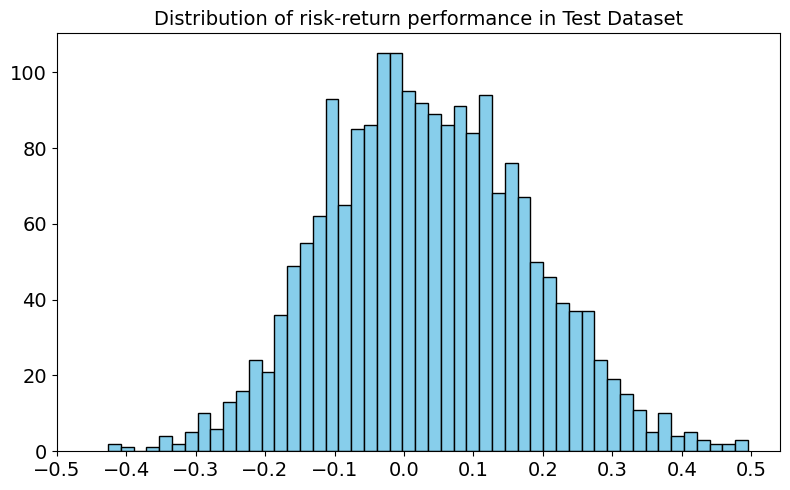

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(EVALUATION['Perform'],bins=50, edgecolor='black',color='skyblue')
plt.title('Distribution of risk-return performance in Test Dataset', fontsize=14)
plt.xticks([i / 10.0 for i in range(-5, 6)], fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('distribution_histograms.jpg', dpi=300)
plt.show()

# MAE of three models

In [119]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(mean_absolute_error(outputs1.flatten().cpu().detach().numpy(), EVALUATION.iloc[:,1].values.flatten()))
print(mean_absolute_error(outputs2.flatten().cpu().detach().numpy(), EVALUATION.iloc[:,1].values.flatten()))
print(mean_absolute_error(outputs3.flatten().cpu().detach().numpy(), EVALUATION.iloc[:,1].values.flatten()))

0.11736770687722248
0.11577301478475784
0.11968807318887303


# Histograms of differences between True and Predicted Values

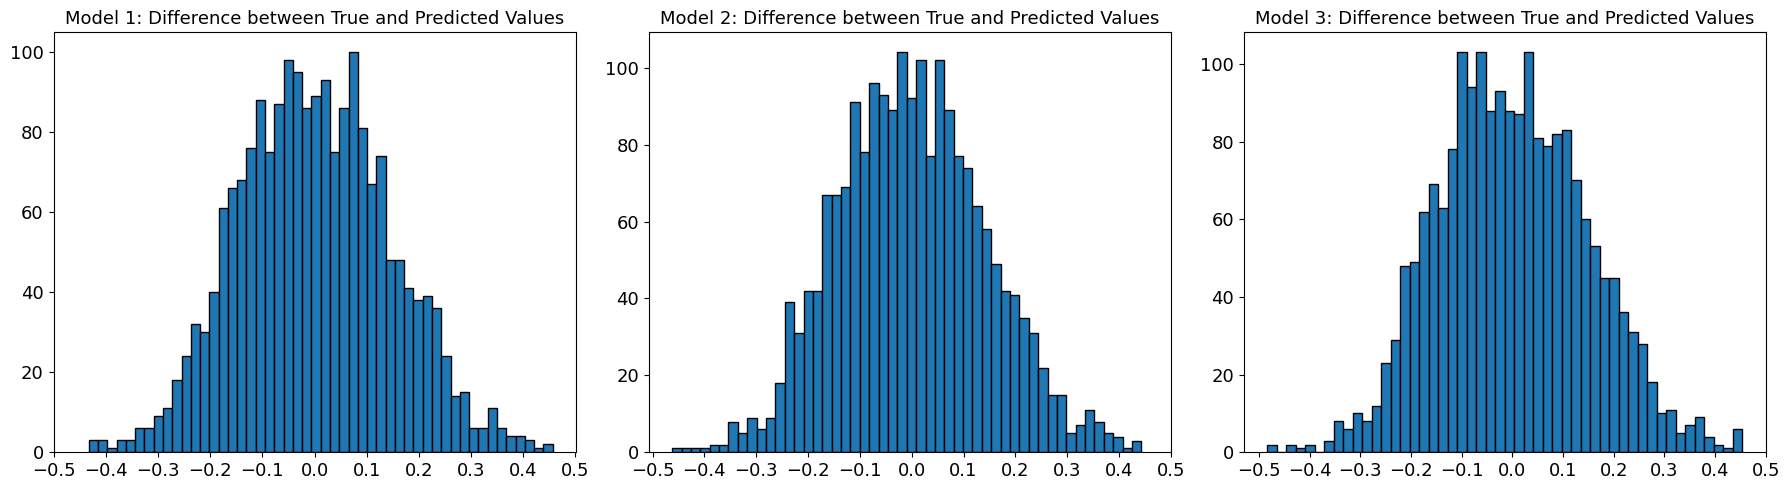

In [135]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plotting the first histogram
axs[0].hist(EVALUATION.iloc[:, 1].values.flatten() - outputs1.flatten().cpu().detach().numpy(), bins=50, edgecolor='black')
axs[0].set_title('Model 1: Difference between True and Predicted Values', fontsize=13)
axs[0].set_xticks([i / 10.0 for i in range(-5, 6)])
axs[0].tick_params(labelsize=13)

# Plotting the second histogram
axs[1].hist(EVALUATION.iloc[:, 1].values.flatten() - outputs2.flatten().cpu().detach().numpy(), bins=50, edgecolor='black')
axs[1].set_title('Model 2: Difference between True and Predicted Values', fontsize=13)
axs[1].set_xticks([i / 10.0 for i in range(-5, 6)])
axs[1].tick_params(labelsize=13)

# Plotting the third histogram
axs[2].hist(EVALUATION.iloc[:, 1].values.flatten() - outputs3.flatten().cpu().detach().numpy(), bins=50, edgecolor='black')
axs[2].set_title('Model 3: Difference between True and Predicted Values', fontsize=13)
axs[2].set_xticks([i / 10.0 for i in range(-5, 6)])
axs[2].tick_params(labelsize=13)
# Adjust layout and save the figure as jpg
plt.tight_layout()
plt.savefig('performance_histograms.jpg', dpi=300)
plt.show()

# Classification

Above models predicts continuous values of risk-return performance (regression). Based on those predicted values we want to classified them as -1 ("Sell"), 0 ("Hold"), 1 ("Buy")

In [121]:
# neural network is configured to predict value 'perform'
# if the 'perform' has value close to 0 then 'class' is 0
# if the 'perform' has small, negative value then 'class' is -1
# and if the 'perform' has big, positive value then 'class' is 1

# I set those limit values based on values from TRAIN
# so basically if we got value which is in (limit_left,limit_right) then class is 0
# if it is less then limit_left then -1 and bigger then limit_right then 1

limit_left = ((TRAIN[TRAIN['Class'] == -1]).iloc[:,-1]).max()
limit_right = ((TRAIN[TRAIN['Class'] == 1]).iloc[:,-1]).min()

print(limit_left)
print(limit_right)

-0.015037764
0.040084855


In [122]:
Predictions1 = torch.zeros_like(outputs1, dtype=torch.int32)

Predictions1[outputs1 < limit_left] = -1
Predictions1[(outputs1 >= limit_left) & (outputs1 <= limit_right)] = 0
Predictions1[outputs1 > limit_right] = 1
Predictions1.flatten()

tensor([-1,  0, -1,  ...,  1,  1,  0], device='cuda:0', dtype=torch.int32)

In [123]:
matrix1 = confusion_matrix(y_pred = Predictions1.flatten().cpu(), y_true = torch.tensor(EVALUATION.iloc[:,0].values.flatten(), dtype=torch.int32), labels=[-1, 0, 1])
matrix1

array([[102, 367, 304],
       [ 37, 119, 129],
       [ 82, 417, 443]])

In [131]:
error_cost_matrix = np.array([[0, 1, 2],
                              [1, 0, 1],
                              [2, 1, 0]])

# Classification Weighted Error from competition
np.sum(matrix1 *error_cost_matrix) / len(Predictions1.flatten())

0.861

In [125]:
Predictions2 = torch.zeros_like(outputs2, dtype=torch.int32)

Predictions2[outputs2 < limit_left] = -1
Predictions2[(outputs2 >= limit_left) & (outputs2 <= limit_right)] = 0
Predictions2[outputs2 > limit_right] = 1
Predictions2.flatten()

tensor([-1,  1,  0,  ...,  0,  1,  0], device='cuda:0', dtype=torch.int32)

In [126]:
matrix2 = confusion_matrix(y_pred =Predictions2.flatten().cpu(),y_true = torch.tensor(EVALUATION.iloc[:,0].values.flatten(), dtype=torch.int32), labels=[-1, 0, 1])
matrix2

array([[ 75, 406, 292],
       [ 19, 143, 123],
       [ 49, 448, 445]])

In [132]:
error_cost_matrix = np.array([[0, 1, 2],
                              [1, 0, 1],
                              [2, 1, 0]])

# Classification Weighted Error from competition
np.sum(matrix2 *error_cost_matrix) / len(Predictions2.flatten())

0.839

In [128]:
Predictions3 = torch.zeros_like(outputs3, dtype=torch.int32)

Predictions3[outputs3 < limit_left] = -1
Predictions3[(outputs3 >= limit_left) & (outputs3 <= limit_right)] = 0
Predictions3[outputs3 > limit_right] = 1
Predictions3.flatten()

tensor([-1,  0, -1,  ...,  1,  1, -1], device='cuda:0', dtype=torch.int32)

In [129]:
matrix3 = confusion_matrix(y_pred =Predictions3.flatten().cpu(), y_true =torch.tensor(EVALUATION.iloc[:,0].values.flatten(), dtype=torch.int32), labels=[-1, 0, 1])
matrix3

array([[126, 325, 322],
       [ 38, 112, 135],
       [126, 376, 440]])

In [133]:
error_cost_matrix = np.array([[0, 1, 2],
                              [1, 0, 1],
                              [2, 1, 0]])

# Classification Weighted Error from competition
np.sum(matrix3 *error_cost_matrix) / len(Predictions3.flatten())

0.885

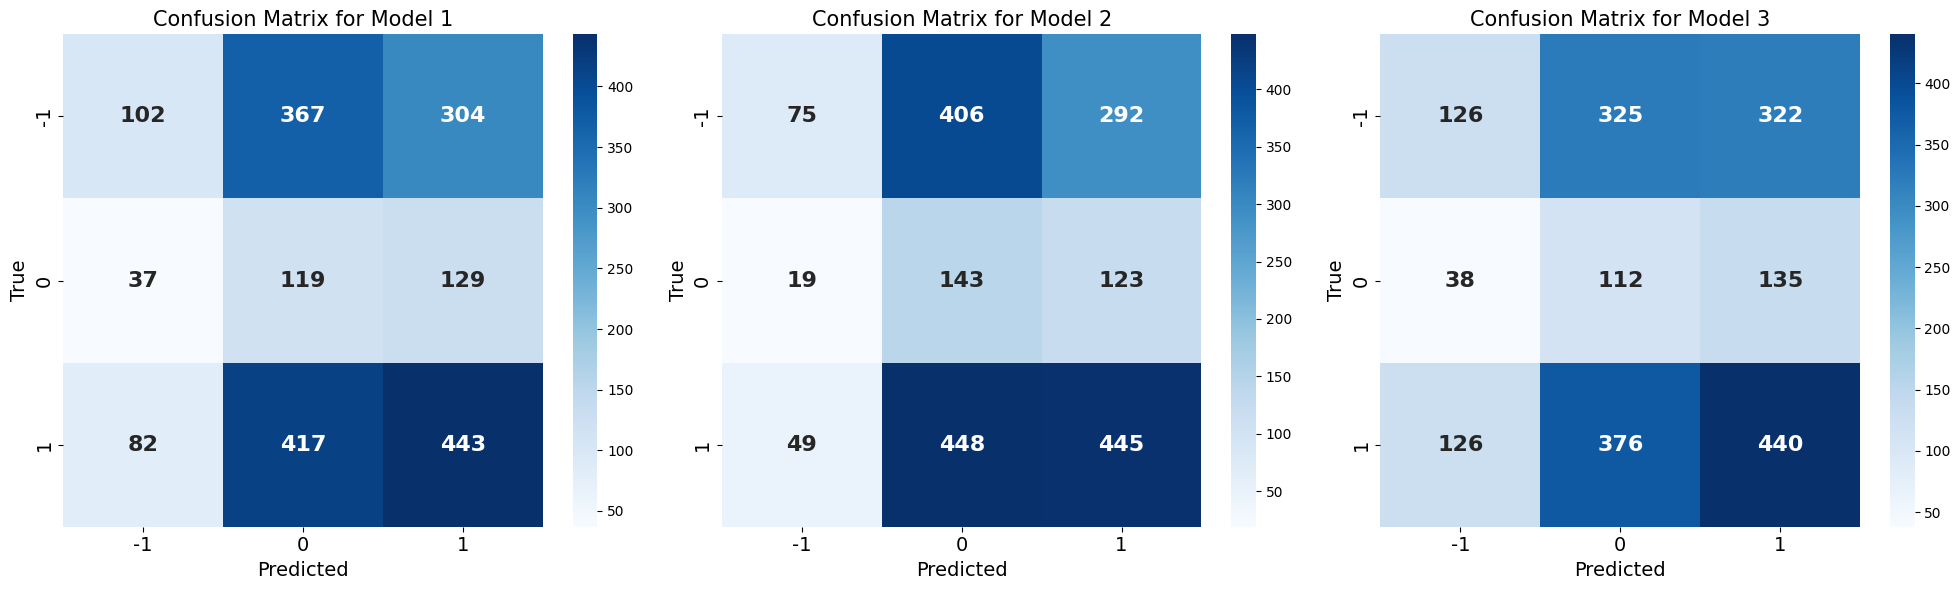

In [136]:
import seaborn as sns

matrices = []
matrices.append(matrix1)
matrices.append(matrix2)
matrices.append(matrix3)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, matrix in enumerate(matrices):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1], ax=axes[i], annot_kws={"size": 16, "weight": "bold"})
    axes[i].set_xlabel('Predicted', fontsize=14)
    axes[i].set_ylabel('True', fontsize=14)
    axes[i].set_title(f'Confusion Matrix for Model {i+1}', fontsize=15)
    axes[i].tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('confusion_matrices_grid.jpg', dpi=300)
plt.show()